In [3]:
library(getopt)
library(ArchR)
library(Seurat)
library(SeuratObject)
library(grid)
library(knitr)
library(ggplot2)
library(patchwork)
library(gridExtra)
library(kableExtra)
library(dplyr)
library(tibble)
library(hdf5r)
library(clusterProfiler)
library(org.Mm.eg.db)
library(org.Hs.eg.db)
library(org.Rn.eg.db)
library(repr)
library(stringr)
library(magick)
library(rjson)
library(SeuratDisk)

In [4]:
source ("./getGeneScore_ArchR.R")
source ("./SpatialPlot_new.R")
source ("./SpatialDimPlot_new.R")
source ("./getDeviation_ArchR.R")


In [ ]:
dataset <- "."
project_name <- "D357"
data_species <- "mm10"
tile_size <- 5000
inputFiles <- paste0(dataset,"/", 'fragments.tsv.gz', sep="")
spatialFolder <- paste0(dataset,"/", 'spatial', sep="")

In [7]:
if (data_species == "hg38") {
  addArchRGenome(data_species)
  geneAnnotation <- getGeneAnnotation()
  genomeAnnotation <- getGenomeAnnotation()
  genomeSize = 3.3e+09
} else if (data_species == "mm10") {
  addArchRGenome(data_species)
  geneAnnotation <- getGeneAnnotation()
  genomeAnnotation <- getGenomeAnnotation()
  genomeSize = 3.0e+09
} else if (data_species == "rnor6") {
  geneAnnotation <- readRDS(file.path(ArchRref, data_species, 'geneAnnotation.rds'))
  genomeAnnotation <- readRDS(file.path(ArchRref, data_species, 'genomeAnnotation.rds'))
  genomeSize = 3.15e+09
} else {
  stop("Error : Organisms other than Mouse/Rat/Human not supported currently")
}

Setting default genome to Mm10.

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!



In [9]:
############### Create ArrowFile and project

ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = project_name,
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnnotation,
  filterTSS = 0,
  filterFrags = 0,
  minFrags = 0,
  maxFrags = 1e+07,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  offsetPlus = 0,
  offsetMinus = 0,
  force = TRUE,
  TileMatParams = list(tileSize = tile_size)
)

proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = project_name,
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnnotation,
  copyArrows = TRUE
)

filterFrags is no longer a valid input. Please use minFrags! Setting filterFrags value to minFrags!

filterTSS is no longer a valid input. Please use minTSS! Setting filterTSS value to minTSS!

ArchR logging to : ArchRLogs/ArchR-createArrows-938f5ac26001-Date-2023-01-19_Time-13-07-36.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2023-01-19 13:07:36 : Batch Execution w/ safelapply!, 0 mins elapsed.

(D357 : 1 of 1) Determining Arrow Method to use!

Attempting to index ./fragments.tsv.gz as tabix..

2023-01-19 13:07:53 : (D357 : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.287 mins elapsed.

2023-01-19 13:07:53 : (D357 : 1 of 1) Tabix Bed To Temporary File, 0.287 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", prefix, round(100 * :
“one argument not used by format '%s Reading TabixFile %s Percent'”
2023-01-19 13:08:27 : (D357 : 1 of 1) Reading TabixFile 10 Percent, 0.858 mins elapsed.

Warni

In [ ]:
############### Prepare metadata  ###############

meta.data <- as.data.frame(getCellColData(ArchRProj = proj))
meta.data['cellID_archr'] <- row.names(meta.data)
new_row_names <- row.names(meta.data)
new_row_names <- unlist(lapply(new_row_names, function(x) gsub(".*#","", x)))
new_row_names <- unlist(lapply(new_row_names, function(x) gsub("-.*","", x)))
row.names(meta.data) <- new_row_names


In [14]:
############### Function for constructing object

Load_AtlasXomicsEpi <- function(
    proj,
    meta.data,
    spatialFolder,
    filter.matrix = TRUE,
    threshold
) {
    image = Read10X_Image( image.dir = spatialFolder, filter.matrix = filter.matrix)
    sequenced_tixels <- row.names(meta.data)
    image <- image[sequenced_tixels, ]
    meta.data.spatial <- meta.data[row.names(image@coordinates), ]
    proj_in_tissue <- proj[meta.data.spatial$cellID_archr, ]
    
    proj_in_tissue <- addIterativeLSI(
        ArchRProj = proj_in_tissue,
        useMatrix = "TileMatrix", 
        name = "IterativeLSI", 
        iterations = 2, 
        clusterParams = list(
           resolution = c(0.2), 
           sampleCells = 10000, 
           n.start = 10
        ), 
        varFeatures = 25000, 
        dimsToUse = 1:30,
        force = TRUE
    )

    proj_in_tissue <- addClusters(
        input = proj_in_tissue,
        reducedDims = "IterativeLSI",
        method = "Seurat",
        name = "Clusters",
        resolution = 0.4,
        force = TRUE
    )

    proj_in_tissue <- addUMAP(
        ArchRProj = proj_in_tissue, 
        reducedDims = "IterativeLSI", 
        name = "UMAP", 
        nNeighbors = 30, 
        minDist = 0.5, 
        metric = "cosine",
        force = TRUE
    )

    proj_in_tissue <- addImputeWeights(proj_in_tissue)

    markersGS <- getMarkerFeatures(
        ArchRProj = proj_in_tissue,
        useMatrix = "GeneScoreMatrix",
        groupBy = "Clusters",
        testMethod = "ttest"
    )

#     For some runs, "FDR < 0.05" won't work
    if ( threshold > 0 ) {
        markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.05 & Log2FC >= threshold")
    } else {
        markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.05 & Log2FC <= threshold")
    }

    markerGenes <- list()
    for (i in seq_len(length(markerList))) {
        markerGenes <- c(markerGenes, markerList[[i]]$name)
    }

    markerGenes <- unlist(markerGenes)

    proj_in_tissue <- addImputeWeights(proj_in_tissue)
    gene_score <- getGeneScore_ArchR(ArchRProj = proj_in_tissue, name = markerGenes, imputeWeights = getImputeWeights(proj_in_tissue))
    object <- CreateSeuratObject(counts = gene_score, assay = "Spatial", meta.data = meta.data)
    image <- image[Cells(x = object)]
    DefaultAssay(object = image) <- "Spatial"
    object[["slice1"]] <- image
    spatial.obj <- object
    objList <- list("proj_in_tissue" = proj_in_tissue
                    , "spatial.obj" = spatial.obj, 'markerList' = markerList
                   )
    return(objList)
}

In [ ]:
threshold <- 0.25
objList <- Load_AtlasXomicsEpi(proj, meta.data, spatialFolder, filter.matrix = FALSE, threshold)


In [16]:
proj_in_tissue <- objList$proj_in_tissue
proj_in_tissue


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /Users/NouroddinSotoudehChafi/Downloads/reports/company/D357/D357 
samples(1): D357
sampleColData names(1): ArrowFiles
cellColData names(14): Sample TSSEnrichment ... BlacklistRatio Clusters
numberOfCells(1): 2500
medianTSS(1): 7.2065
medianFrags(1): 31733.5

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-b6d45a4ca264-Date-2023-02-02_Time-07-03-51.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-b6d45a4ca264-Date-2023-02-02_Time-07-03-51.log



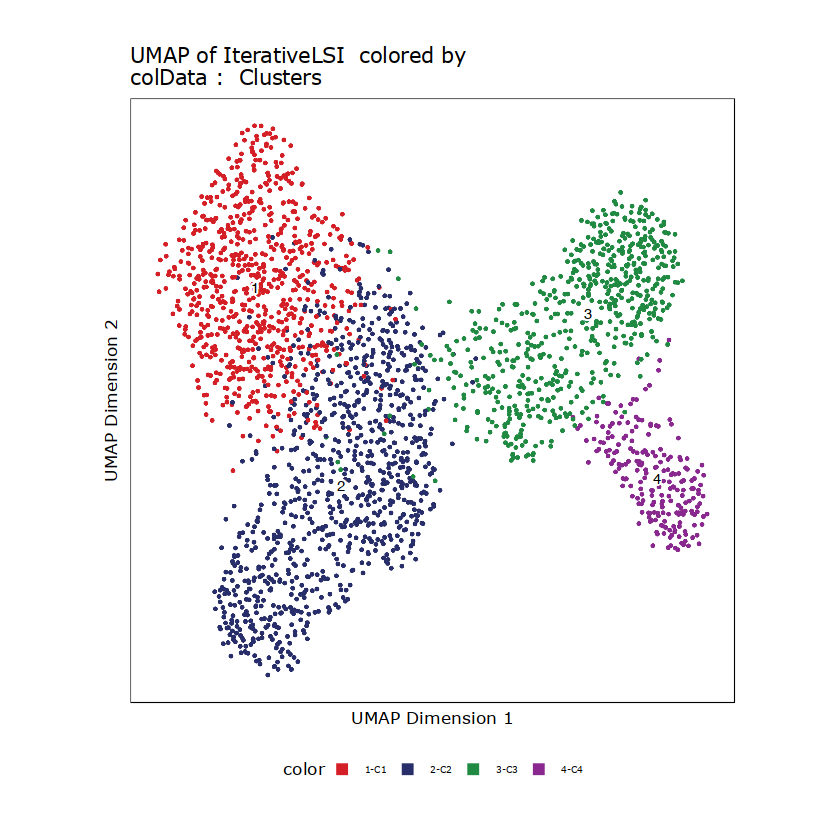

In [17]:
# p1 <- plotEmbedding(ArchRProj = proj_in_tissue, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj_in_tissue, colorBy = "cellColData"
                    , name = "Clusters", embedding = "UMAP",size = 1.0)
# ggAlignPlots(p1, p2, type = "h")
p2

In [22]:
markersGS <- getMarkerFeatures(
        ArchRProj = proj_in_tissue,
        useMatrix = "GeneScoreMatrix",
        groupBy = "Clusters",
        testMethod = "ttest"
    )

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-b6d46a683e24-Date-2023-02-02_Time-07-03-57.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2023-02-02 07:03:57 : Matching Known Biases, 0 mins elapsed.

2023-02-02 07:03:57 : Computing Pairwise Tests (1 of 4), 0.004 mins elapsed.

Pairwise Test C1 : Seqnames chr1

Pairwise Test C1 : Seqnames chr10

Pairwise Test C1 : Seqnames chr11

Pairwise Test C1 : Seqnames chr12

Pairwise Test C1 : Seqnames chr13

Pairwise Test C1 : Seqnames chr14

Pairwise Test C1 : Seqnames chr15

Pairwise Test C1 : Seqnames chr16

Pairwise Test C1 : Seqnames chr17

Pairwise Test C1 : Seqnames chr18

Pairwise Test C1 : Seqnames chr19

Pairwise Test C1 : Seqnames chr2

Pairwise Test C1 : Seqnames chr3

Pairwise Test C1 : Seqnames chr4

Pairwise Test C1 : Seqnames chr5

Pairwise Test C1 : Seqnames chr6

Pairwise Test C1 : Seqnames chr7

Pairwise Test C1 : Seqnames chr8

Pairwise Test C1 : Seqnames chr9

Pairwis

In [23]:
############### Build all and on tissue objects

objList <- Load_AtlasXomicsEpi(proj, meta.data, spatialFolder, filter.matrix = FALSE, threshold)
proj_all <- objList$proj_in_tissue
spatial_all.obj <- objList$spatial.obj
spatial_all.obj$orig.ident = as.factor(project_name)
Idents(spatial_all.obj) = 'orig.ident'
spatial_all.obj = AddMetaData(spatial_all.obj, spatial_all.obj@images$slice1@coordinates)
Idents(spatial_all.obj) = 'tissue'

objList <- Load_AtlasXomicsEpi(proj, meta.data, spatialFolder, filter.matrix = TRUE, threshold)
proj_in_tissue <- objList$proj_in_tissue
spatial_in_tissue.obj <- objList$spatial.obj
markerList <- objList$markerList
spatial_in_tissue.obj$orig.ident = as.factor(project_name)
Idents(spatial_in_tissue.obj) = 'orig.ident'
spatial_in_tissue.obj = AddMetaData(spatial_in_tissue.obj, spatial_in_tissue.obj@images$slice1@coordinates)
Idents(spatial_in_tissue.obj) = 'tissue'


Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-b6d461c7e40f-Date-2023-02-02_Time-07-04-37.log
If there is an issue, please report to github with logFile!

2023-02-02 07:04:37 : Computing Total Across All Features, 0 mins elapsed.

2023-02-02 07:04:37 : Computing Top Features, 0.003 mins elapsed.

###########
2023-02-02 07:04:38 : Running LSI (1 of 2) on Top Features, 0.009 mins elapsed.
###########

2023-02-02 07:04:38 : Creating Partial Matrix, 0.009 mins elapsed.

2023-02-02 07:04:46 : Computing LSI, 0.158 mins elapsed.

2023-02-02 07:05:02 : Identifying Clusters, 0.423 mins elapsed.

2023-02-02 07:05:05 : Identified 3 Clusters, 0.461 mins elapsed.

2023-02-02 07:05:05 : Saving LSI Iteration, 0.461 mins elapsed.

2023-02-02 07:05:12 : Creating Cluster Matrix on the total Group Features, 0.583 mins elapsed.

2023-02-02 07:05:32 : Computing Variable Features, 0.916 mins elapsed.

###########
2023-02-02 07:05:32 : Running LSI (2 of 2) on Variable Features, 0.917 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2500
Number of edges: 163397

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8374
Number of communities: 4
Elapsed time: 0 seconds


2023-02-02 07:05:57 : Testing Outlier Clusters, 0.039 mins elapsed.

2023-02-02 07:05:57 : Assigning Cluster Names to 4 Clusters, 0.039 mins elapsed.

2023-02-02 07:05:57 : Finished addClusters, 0.04 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

07:05:57 UMAP embedding parameters a = 0.583 b = 1.334

07:05:57 Read 2500 rows and found 29 numeric columns

07:05:57 Using Annoy for neighbor search, n_neighbors = 30

07:05:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:05:57 Writing NN index file to temp file /var/folders/19/5vrsks2166z0l3b994vmcj8c0000gp/T//Rtmpiu2LjS/fileb6d43aefffc0

07:05:57 Searching Annoy index using 5 threads, search_k = 3000

07:05:57 Annoy recall = 100%

07:05:58 Commencing smooth kNN distance calibration using 5 thr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1782
Number of edges: 120387

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8318
Number of communities: 4
Elapsed time: 0 seconds


2023-02-02 07:08:11 : Testing Outlier Clusters, 0.028 mins elapsed.

2023-02-02 07:08:11 : Assigning Cluster Names to 4 Clusters, 0.028 mins elapsed.

2023-02-02 07:08:11 : Finished addClusters, 0.028 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

07:08:11 UMAP embedding parameters a = 0.583 b = 1.334

07:08:11 Read 1782 rows and found 29 numeric columns

07:08:11 Using Annoy for neighbor search, n_neighbors = 30

07:08:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:08:12 Writing NN index file to temp file /var/folders/19/5vrsks2166z0l3b994vmcj8c0000gp/T//Rtmpiu2LjS/fileb6d44f74216a

07:08:12 Searching Annoy index using 5 threads, search_k = 3000

07:08:12 Annoy recall = 100%

07:08:12 Commencing smooth kNN distance calibration using 5 th

In [24]:
############### Summary statistics

NCount_mean = mean(spatial_in_tissue.obj@meta.data$nFrags)
NCount_std = sd(spatial_in_tissue.obj@meta.data$nFrags)
NCount_min = min(spatial_in_tissue.obj@meta.data$nFrags)
NCount_max = max(spatial_in_tissue.obj@meta.data$nFrags)
N_Tixels = sum(spatial_in_tissue.obj@images$slice1@coordinates$tissue)

if(!0 %in% Idents(spatial_all.obj)){
  Idents(spatial_all.obj) = 'orig.ident'  
  NCount_mean_NT = 0
  NCount_std_NT = 0
  NCount_min_NT = 0
  NCount_max_NT = 0
  percent_umi_off_tissue = 0
} else {
  spatial_none.obj = subset(spatial_all.obj, ident = 0)  
  NCount_mean_NT = mean(spatial_none.obj@meta.data$nFrags)
  NCount_std_NT = sd(spatial_none.obj@meta.data$nFrags)
  NCount_min_NT = min(spatial_none.obj@meta.data$nFrags)
  NCount_max_NT = max(spatial_none.obj@meta.data$nFrags)  
  percent_umi_off_tissue = sum(spatial_none.obj@meta.data$nFrags)/(sum(spatial_none.obj@meta.data$nFrags)+sum(spatial_in_tissue.obj@meta.data$nFrags))
}

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-b6d420281397-Date-2023-02-02_Time-07-13-45.log
If there is an issue, please report to github with logFile!

2023-02-02 07:13:45 : D357 Computing FragmentSizes (1 of 1)!, 0.001 mins elapsed.

2023-02-02 07:14:05 : D357 Finished Computing FragmentSizes (1 of 1)!, 0.337 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-b6d420281397-Date-2023-02-02_Time-07-13-45.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-b6d4271e2eff-Date-2023-02-02_Time-07-14-05.log
If there is an issue, please report to github with logFile!

2023-02-02 07:14:06 : D357 Computing TSS (1 of 1)!, 0.003 mins elapsed.

2023-02-02 07:15:03 : D357 Finished Computing TSS (1 of 1)!, 0.959 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-b6d4271e2eff-Date-2023-02-02_Time-07-14-05.log



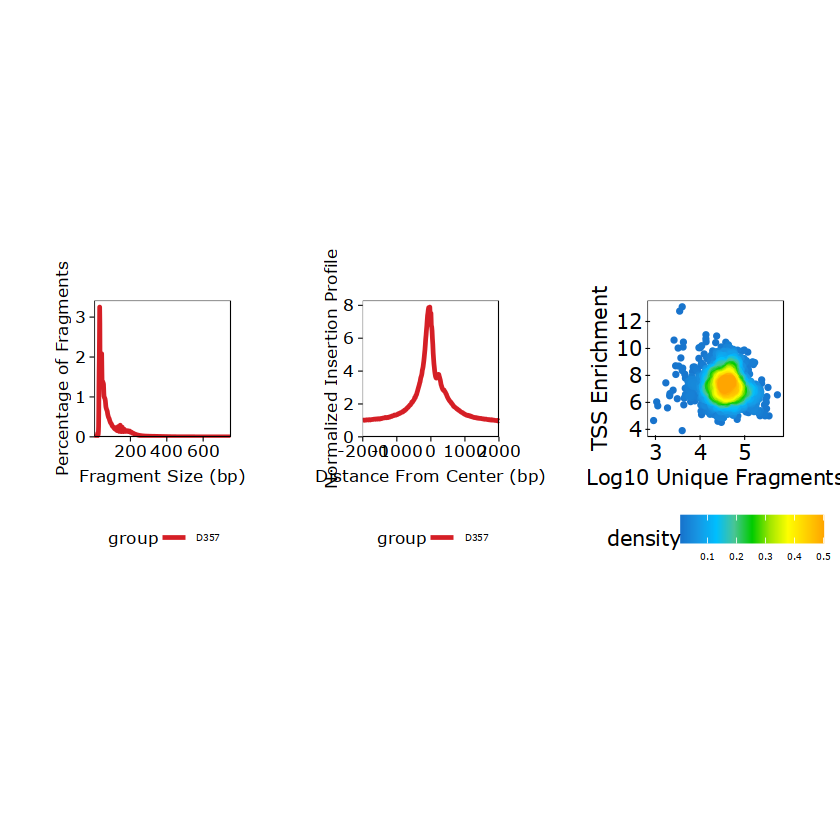

In [26]:
############### TSS and fragment distributions Plots

plot_frag_size <- plotFragmentSizes(ArchRProj = proj_in_tissue) + labs(x = "Fragment Size (bp)") + theme(text=element_text(size=21))
plot_tss_enrich <- plotTSSEnrichment(ArchRProj = proj_in_tissue) + theme(text=element_text(size=21))
df <- getCellColData(proj_in_tissue, select = c("log10(nFrags)", "TSSEnrichment"))
plot_uniq_frag <- ggPoint(
    x = df[,1],
    y = df[,2],
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    #xlim = c(log10(100), 5),
    #ylim = c(0, 14),
    baseSize = 12
)
layout <- '
ABC
'
frag_tss_Plot = wrap_plots(A=plot_frag_size, B=plot_tss_enrich, C=plot_uniq_frag, design=layout)
frag_tss_Plot

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-b6d440926118-Date-2023-02-02_Time-07-15-23.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-b6d440926118-Date-2023-02-02_Time-07-15-23.log



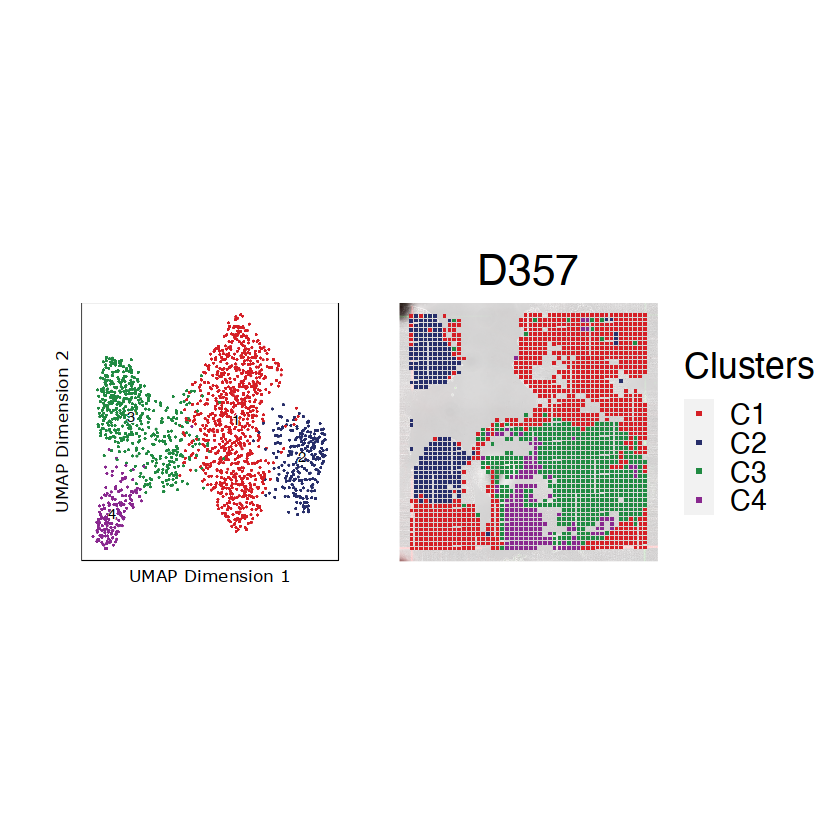

In [31]:
pt_size_factor <- 1
############### DimPlot

plot_umap_cluster = plotEmbedding(
    ArchRProj = proj_in_tissue,
    discreteSet = "stallion",
    colorBy = "cellColData",
    name = "Clusters",
    embedding = "UMAP",
    size = 2) +
    theme(
      plot.title = element_blank(),
      legend.position = "none",
      text=element_text(size=21))

n_clusters <- length(unique(proj_in_tissue$Clusters))
cols <- ArchRPalettes$stallion[as.character(seq_len(n_clusters))]
names(cols) <- paste0('C', seq_len(n_clusters))

spatial_in_tissue.obj@meta.data$Clusters = proj_in_tissue$Clusters
plot_spatial = SpatialDimPlot(
    spatial_in_tissue.obj,
    group.by = "Clusters",
    label = FALSE, label.size = 3,
    pt.size.factor = pt_size_factor, cols = cols, stroke = 0) + 
    theme(
      plot.title = element_blank(),
      legend.position = "right",
      text=element_text(size=21)) +
     ggtitle(project_name) + theme(plot.title = element_text(hjust = 0.5), text=element_text(size=21)) 

plot_spatial$layers[[1]]$aes_params <-
    c(plot_spatial$layers[[1]]$aes_params, shape=22)

plot_umap_cluster = wrap_plots(plot_umap_cluster, plot_spatial)
plot_umap_cluster


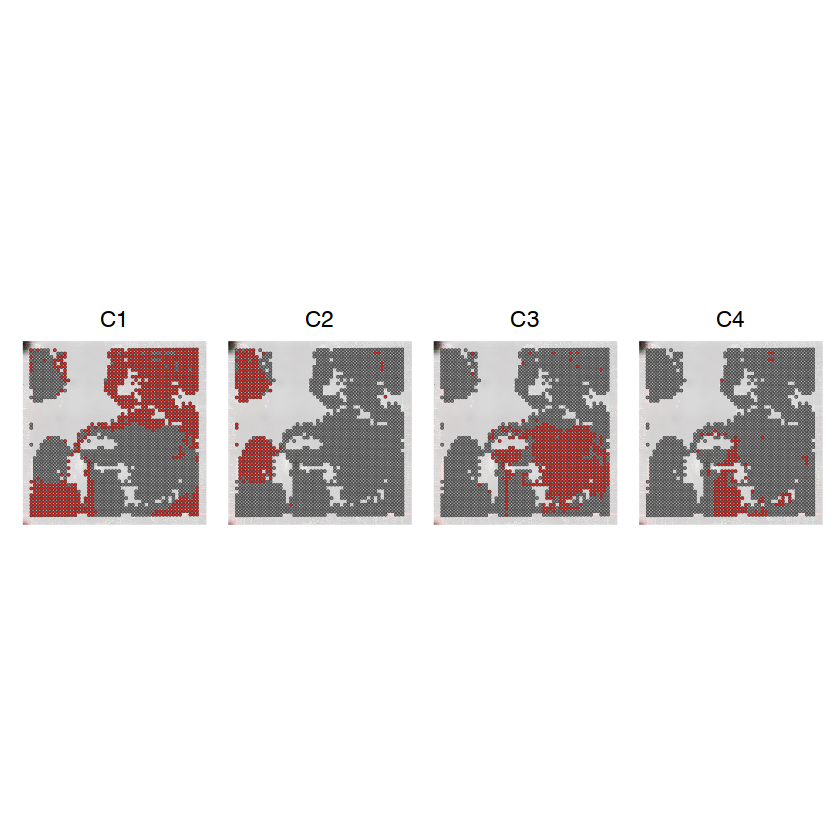

In [32]:
############### Individual cluster plots

Idents(spatial_in_tissue.obj) = 'Clusters'
plot_spatial_facet = SpatialDimPlot(
    object = spatial_in_tissue.obj,
    cells.highlight = CellsByIdentities(object = spatial_in_tissue.obj, idents=sort(unique(proj_in_tissue$Clusters))),
    facet.highlight = TRUE, ncol = 4, pt.size.factor = pt_size_factor)
Idents(spatial_in_tissue.obj) = 'orig.ident'
plot_spatial_facet

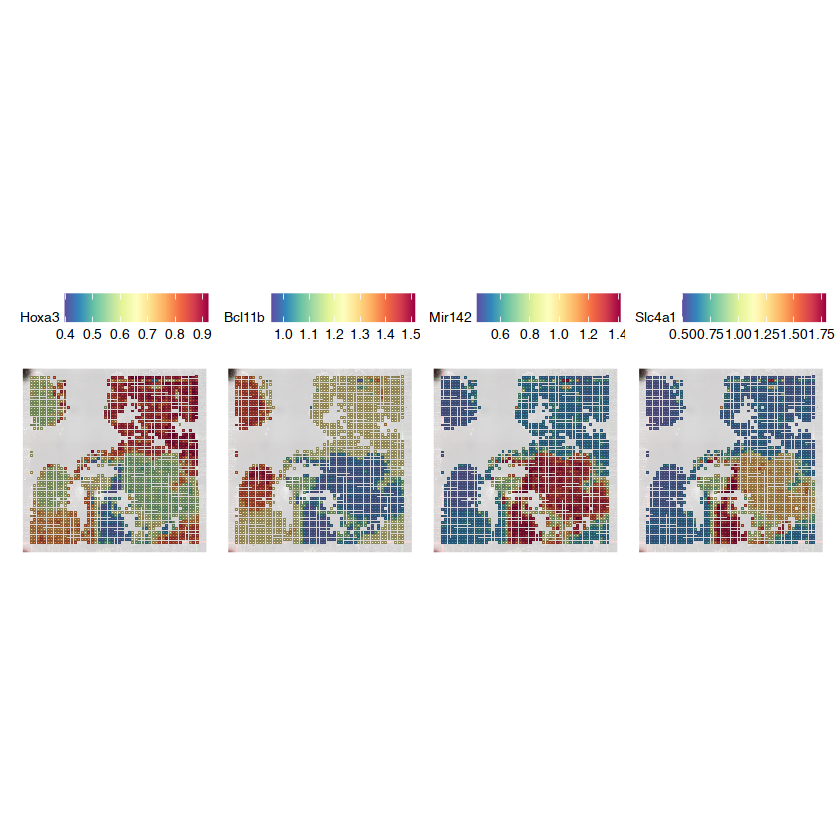

In [34]:
############### Spatially variable gene in each cluster

markerList <- objList$markerList

markerGenes <- list()
    for (i in seq_len(length(markerList))) {
            markerGenes <- c(markerGenes, markerList[[i]]$name[4])
    }

topGenes <- unlist(markerGenes)
topGenes <- topGenes[!is.na(topGenes)]
top_list <- list()
for(i in topGenes){
  top_list[[i]] <- SpatialFeaturePlot(spatial_in_tissue.obj, features = i, ncol = 1, alpha = c(.8, 2), pt.size.factor = pt_size_factor) +
      theme(legend.position = "top", legend.text=element_text(size=8), legend.title=element_text(size=8))
  top_list[[i]]$layers[[1]]$aes_params <-
    c(top_list[[i]]$layers[[1]]$aes_params, shape=22)  
}
top_spatial_plots <- wrap_plots(top_list, ncol = 4)
top_spatial_plots




# Cell type

# MOCA E11

In [35]:
MOCA_dir <- "~/Downloads/reports/D188_report/MOCA/"

meta.data.RNA <- read.csv(file = paste0(MOCA_dir, 'cell_annotate.csv'), header = TRUE, row.names = 1, stringsAsFactors = FALSE)
gene.ANN.RNA <- read.csv(file = paste0(MOCA_dir, 'gene_annotate.csv'), header = TRUE, row.names = 1, stringsAsFactors = FALSE)
gene.ANN.RNA <- gene.ANN.RNA[, 'gene_short_name', drop = FALSE]

cds <- readRDS(paste0(MOCA_dir, 'gene_count_cleaned_sampled_100k.RDS'))

MOCA <- CreateSeuratObject(counts = cds, project = 'MOCA')
meta.data.RNA <- meta.data.RNA[colnames(MOCA), ]
meta.data.RNA <- meta.data.RNA[, c('Main_cell_type', 'development_stage')]

MOCA <- AddMetaData(object = MOCA, metadata = meta.data.RNA)

MOCA_E11 <- subset(MOCA, development_stage == 11.5) # change the day
MOCA_E11.raw.data <- as.matrix(GetAssayData(MOCA_E11, slot = 'counts'))
MOCA_E11.raw.data <- as.data.frame(MOCA_E11.raw.data)
MOCA_E11.raw.data <- merge(gene.ANN.RNA, MOCA_E11.raw.data, by=0, all=TRUE)
which(is.na(MOCA_E11.raw.data$gene_short_name))

# Remove duplicated names, only keep the first one
tt <- table(MOCA_E11.raw.data$gene_short_name)
name_rep <- names(which(tt > 1))
row_del_fun <- function(x){
  rows <- which(MOCA_E11.raw.data$gene_short_name == x)
  return(rows[2:length(rows)] )
}
row_del <- unlist(lapply(name_rep, row_del_fun))
MOCA_E11.raw.data <- MOCA_E11.raw.data[-row_del, ]

row.names(MOCA_E11.raw.data) <- MOCA_E11.raw.data$gene_short_name
MOCA_E11.raw.data <- MOCA_E11.raw.data[, -c(1:2), drop=FALSE]
MOCA_E11 <- CreateSeuratObject(counts = MOCA_E11.raw.data, project = 'MOCA_E11', meta.data = MOCA_E11@meta.data)







Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.6 GiB”


integer(0)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [36]:
seRNA <- MOCA_E11
seRNA

An object of class Seurat 
26158 features across 33802 samples within 1 assay 
Active assay: RNA (26158 features, 0 variable features)

In [37]:
proj_in_tissue <- addGeneIntegrationMatrix(
  ArchRProj = proj_in_tissue, 
  useMatrix = "GeneScoreMatrix",
  matrixName = "GeneIntegrationMatrix",
  reducedDims = "IterativeLSI",
  seRNA = MOCA_E11,
  addToArrow = TRUE,
  groupRNA = "Main_cell_type",
  nameCell = "predictedCell_Un",
  nameGroup = "predictedGroup_Un",
  nameScore = "predictedScore_Un",
  force = TRUE
)

meta.data <- as.data.frame(getCellColData(ArchRProj = proj_in_tissue))

meta.data.integration <- as.data.frame(getCellColData(ArchRProj = proj_in_tissue))[, c('predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un')]
new_row_names <- row.names(meta.data.integration)
new_row_names <- unlist(lapply(new_row_names, function(x) gsub(".*#","", x)))
new_row_names <- unlist(lapply(new_row_names, function(x) gsub("-.*","", x)))
row.names(meta.data.integration) <- new_row_names



ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-b6d42826b70f-Date-2023-02-02_Time-07-18-23.log
If there is an issue, please report to github with logFile!

2023-02-02 07:18:23 : Running Seurat's Integration Stuart* et al 2019, 0.002 mins elapsed.

2023-02-02 07:18:23 : Checking ATAC Input, 0.003 mins elapsed.

2023-02-02 07:18:23 : Checking RNA Input, 0.004 mins elapsed.

2023-02-02 07:18:25 : Found 18328 overlapping gene names from gene scores and rna matrix!, 0.042 mins elapsed.

2023-02-02 07:18:25 : Creating Integration Blocks, 0.042 mins elapsed.

2023-02-02 07:18:25 : Prepping Interation Data, 0.045 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2023-02-02 07:18:26 : Computing Integration in 1 Integration Blocks!, 0 mins elapsed.

2023-02-02 07:18:26 : Block (1 of 1) : Computing Integration, 0 mins elapsed.

2023-02-02 07:18:26 : Block (1 of 1) : Identifying Variable Genes, 0.007 mins elapsed.

2023-02-02 07:18:27 : Block (1 of 1) : Getting Gen

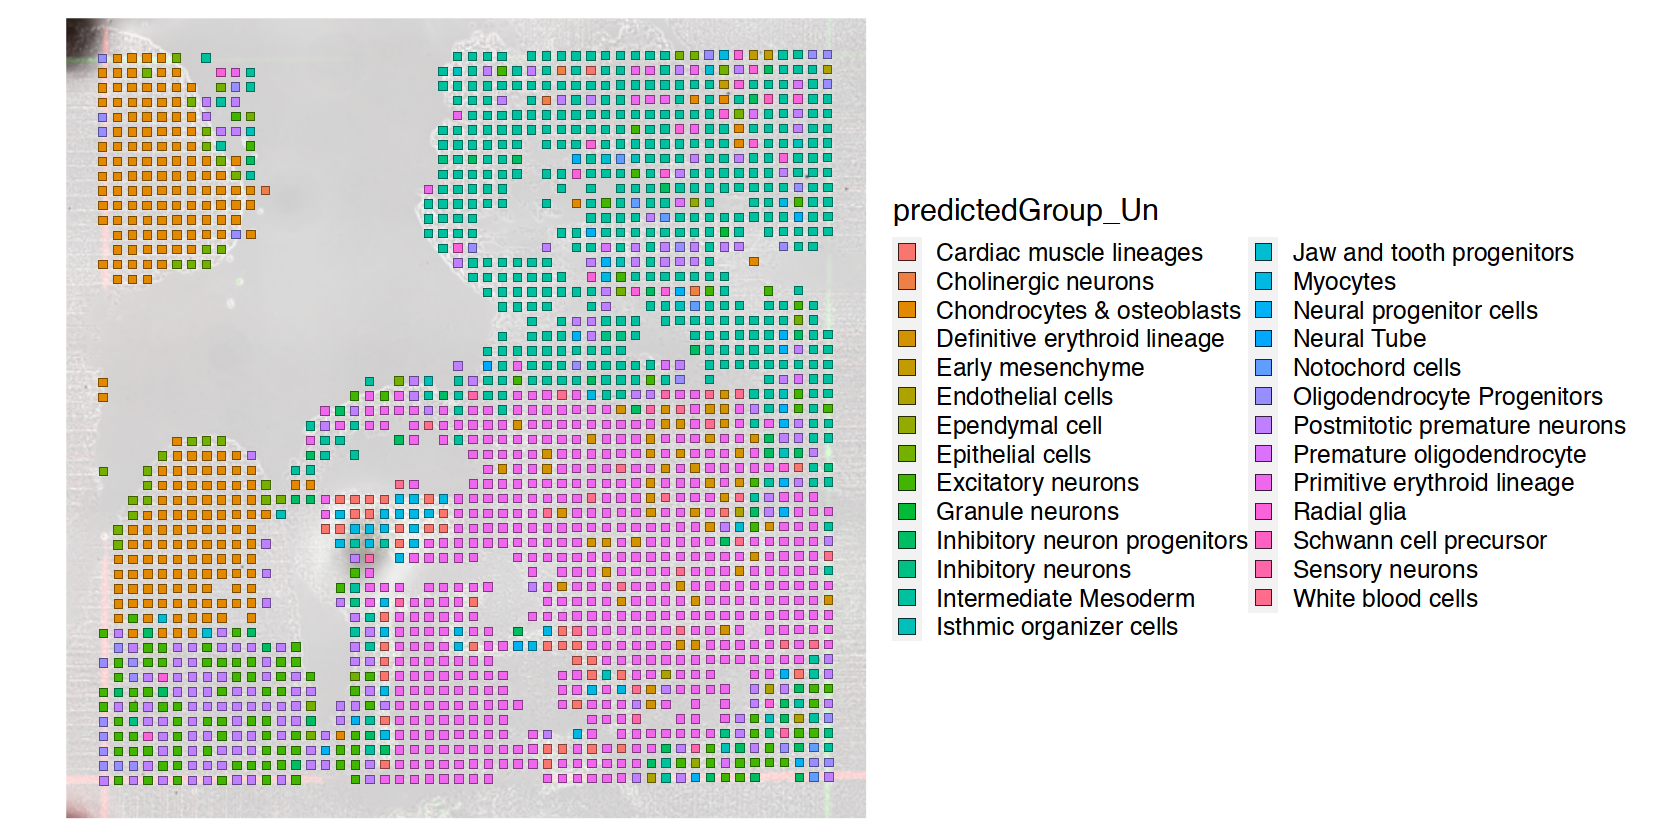

In [40]:
                               
spatial.obj <- AddMetaData(object = spatial.obj, metadata = meta.data.integration)



cell_type_plot <- SpatialDimPlot(spatial.obj, label = FALSE, group.by = 'predictedGroup_Un', pt.size.factor = pt_size_factor) + theme(text=element_text(size=18)) + guides(fill = guide_legend(override.aes = list(size=5), ncol=2))
cell_type_plot$layers[[1]]$aes_params <- c(cell_type_plot$layers[[1]]$aes_params, shape=22)

options(repr.plot.width=14, repr.plot.height=7)

cell_type_plot

In [42]:
required_cell_types <- c(
'Chondrocytes & osteoblasts',
# 'Excitatory neurons',
    'Intermediate Mesoderm',
'Postmitotic premature neurons',
    'Primitive erythroid lineage'


)

In [43]:
MOCA_E11_2 <- MOCA_E11[,which(MOCA_E11@meta.data$Main_cell_type%in%required_cell_types)]
table(MOCA_E11_2@meta.data$Main_cell_type)


   Chondrocytes & osteoblasts         Intermediate Mesoderm 
                         4167                          2126 
Postmitotic premature neurons   Primitive erythroid lineage 
                         1919                           376 

In [44]:
proj_in_tissue <- addGeneIntegrationMatrix(
  ArchRProj = proj_in_tissue, 
  useMatrix = "GeneScoreMatrix",
  matrixName = "GeneIntegrationMatrix",
  reducedDims = "IterativeLSI",
  seRNA = MOCA_E11_2,
  addToArrow = TRUE,
  groupRNA = "Main_cell_type",
  nameCell = "predictedCell_Un",
  nameGroup = "predictedGroup_Un",
  nameScore = "predictedScore_Un",
  force = TRUE
)

meta.data <- as.data.frame(getCellColData(ArchRProj = proj_in_tissue))

meta.data.integration <- as.data.frame(getCellColData(ArchRProj = proj_in_tissue))[, c('predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un')]
new_row_names <- row.names(meta.data.integration)
new_row_names <- unlist(lapply(new_row_names, function(x) gsub(".*#","", x)))
new_row_names <- unlist(lapply(new_row_names, function(x) gsub("-.*","", x)))
row.names(meta.data.integration) <- new_row_names

                               


ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-b6d44963558e-Date-2023-02-02_Time-07-23-25.log
If there is an issue, please report to github with logFile!

2023-02-02 07:23:25 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2023-02-02 07:23:25 : Checking ATAC Input, 0.002 mins elapsed.

2023-02-02 07:23:25 : Checking RNA Input, 0.002 mins elapsed.

2023-02-02 07:23:26 : Found 18328 overlapping gene names from gene scores and rna matrix!, 0.014 mins elapsed.

2023-02-02 07:23:26 : Creating Integration Blocks, 0.014 mins elapsed.

2023-02-02 07:23:26 : Prepping Interation Data, 0.015 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2023-02-02 07:23:26 : Computing Integration in 1 Integration Blocks!, 0 mins elapsed.

2023-02-02 07:23:26 : Block (1 of 1) : Computing Integration, 0 mins elapsed.

2023-02-02 07:23:26 : Block (1 of 1) : Identifying Variable Genes, 0.003 mins elapsed.

2023-02-02 07:23:27 : Block (1 of 1) : Getting Gen

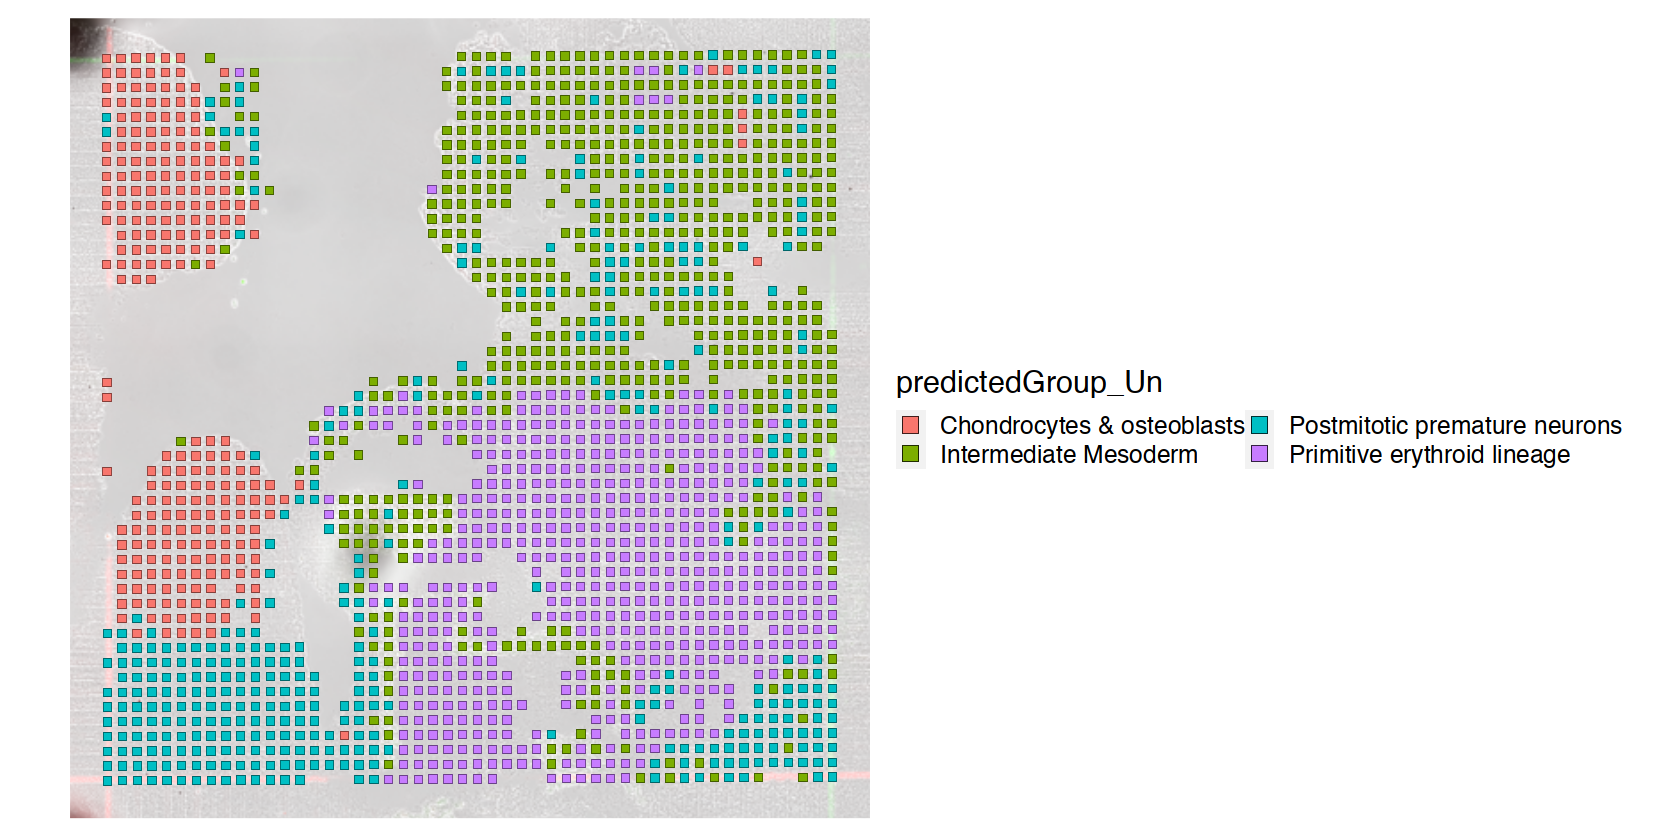

In [45]:
spatial.obj <- AddMetaData(object = spatial.obj, metadata = meta.data.integration)



cell_type_plot <- SpatialDimPlot(spatial.obj, label = FALSE, group.by = 'predictedGroup_Un', pt.size.factor = pt_size_factor) + theme(text=element_text(size=18)) + guides(fill = guide_legend(override.aes = list(size=5), ncol=2))
cell_type_plot$layers[[1]]$aes_params <- c(cell_type_plot$layers[[1]]$aes_params, shape=22)

options(repr.plot.width=14, repr.plot.height=7)

cell_type_plot

Warning message in melt(table(req_DF$Clusters, req_DF$predictedGroup_Un)):
“The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(table(req_DF$Clusters, req_DF$predictedGroup_Un)). In the next version, this warning will become an error.”


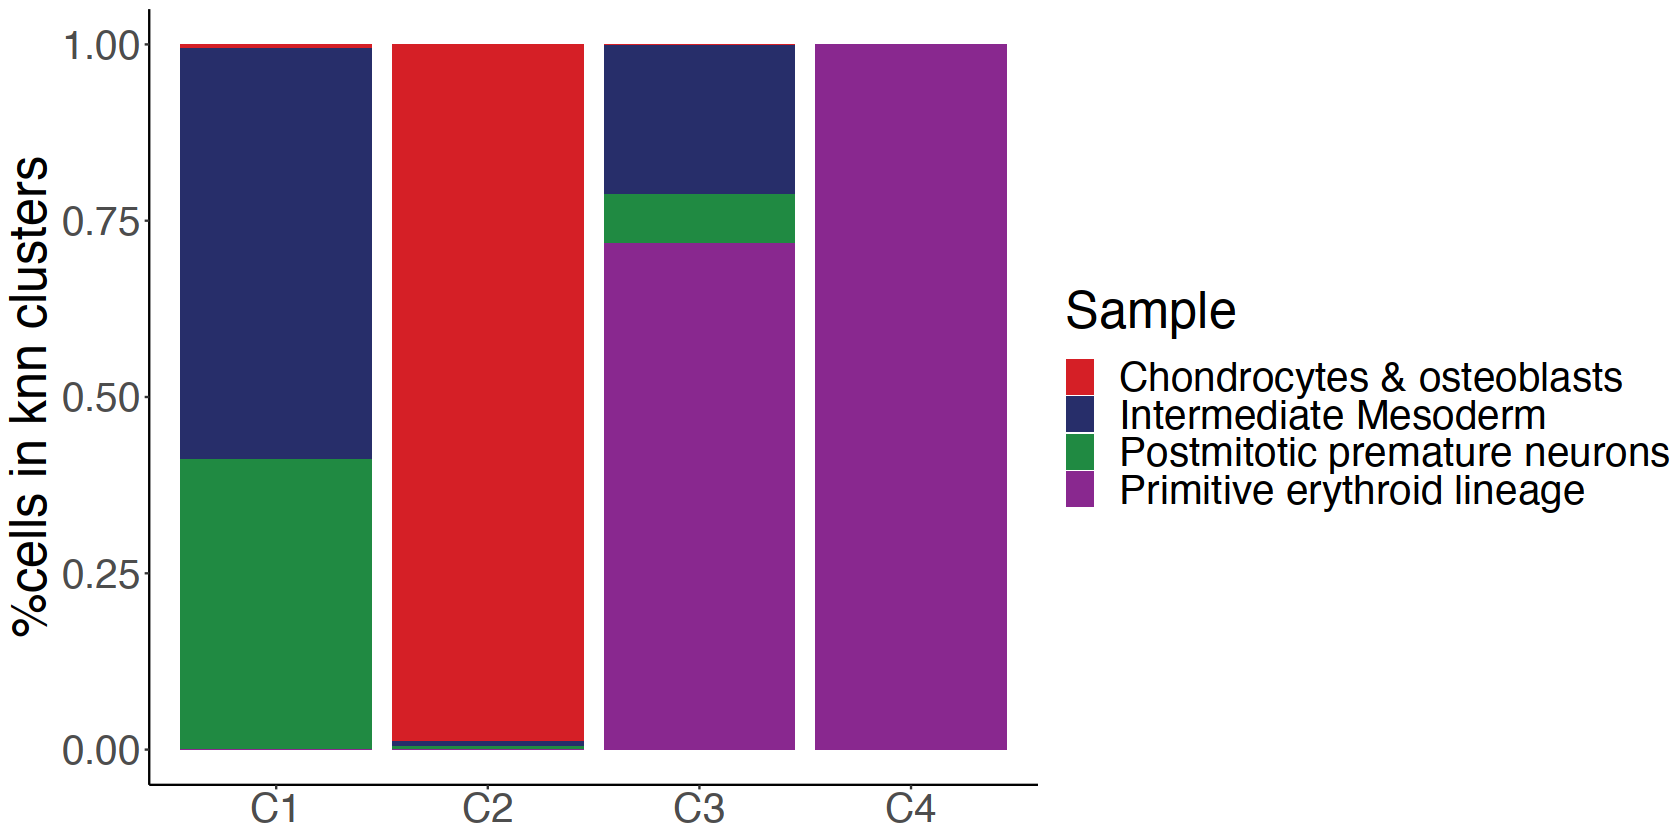

In [47]:
options(repr.plot.width=14, repr.plot.height=7)

pal <- paletteDiscrete(values = unique(proj_in_tissue$predictedGroup_Un))

req_DF <- as.data.frame(getCellColData(proj_in_tissue))

req_table <- melt(table(req_DF$Clusters,req_DF$predictedGroup_Un))
colnames(req_table) <- c("Cluster","Sample","%cells in knn clusters")

req_table$Cluster <- factor(req_table$Cluster                        
                 , levels = (unique(req_table[order(as.numeric(gsub("C","",req_table$Cluster))),]$Cluster)))

ggplot(req_table, aes(fill=Sample, y=`%cells in knn clusters`, x= Cluster))+ 
        geom_bar(stat="identity", position = "fill")+
theme_classic() + 
# scale_fill_manual( values=c("#D51F26", "#272E6A")) +
theme(text = element_text(size = 30)) +
  theme(
        axis.title.x=element_blank(),
      )+
  scale_fill_manual(values= (pal))


In [ ]:
# trajectory looks like C2 C1 C3 C4

# ATAC seq meta data preparation for scenic+

In [ ]:
# make a barcodes column
meta.data <- spatial.obj@meta.data

meta.data$barcodes <- paste0(rownames(meta.data),"-1")


# # change rownames with ___ split
rownames(meta.data) <- paste0(meta.data$barcodes,"___",meta.data$Sample)

meta.data$Sample <- gsub("D357","D00357",meta.data$Sample)


In [51]:
write.csv(meta.data,"./scenicplus/scATAC/metadata_atac.csv")

# Convert scRNA count matrix to h5 file

In [50]:
library(org.Mm.eg.db)
gene_id <-  mapIds(org.Mm.eg.db, my_genes, keytype="SYMBOL", column="ENSEMBL", multiVals = "first")

ERROR: Error in mapIds_base(x, keys, column, keytype, ..., multiVals = multiVals): object 'my_genes' not found


In [ ]:
genes_info<- na.omit(data.frame(gene_id))


In [140]:
scrna <- MOCA_E11_2[which(rownames(MOCA_E11_2)%in%rownames(genes_info)),]
scrna

An object of class Seurat 
18831 features across 8588 samples within 1 assay 
Active assay: RNA (18831 features, 0 variable features)

In [141]:
my.counts <- scrna@assays$RNA@counts
cell.ids <- colnames(scrna)


In [158]:

genes_info <- data.frame(genes_info,X = rownames(genes_info))
colnames(genes_info) <- NULL


In [160]:
# save sparse matrix
sparse.gbm <- my.counts
# head(sparse.gbm)
writeMM(obj = sparse.gbm, file="./scenicplus/scRNA_preprocessing/scRNA/matrix.mtx")

# # save genes and cells names
write.table(x = genes_info, file = "./scenicplus/scRNA_preprocessing/scRNA/genes.tsv", sep = "\t", row.names = F)
write(x = cell.ids, file = "./scenicplus/scRNA_preprocessing/scRNA/barcodes.tsv")

NULL

In [169]:
write.csv(scrna@meta.data,'./scenicplus/scRNA_preprocessing/scRNA/metadata_rna.csv')

In [74]:
mtx <- as.data.frame.matrix(Matrix::readMM('./scenicplus/scRNA_preprocessing/scRNA/matrix.mtx'))


# fragment Preparation

In [2]:
library(data.table)

In [3]:
fragments_D00357 <- fread("fragments.tsv.gz"
#                    ,fill=TRUE
                  )

colnames(fragments_D00357)<- c('chrom','chromStart','chromEnd','barcode','readSupport')
head(fragments_D00357)

Warning message in fread("fragments.tsv.gz"):
“Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end.”


chrom,chromStart,chromEnd,barcode,readSupport
<chr>,<int>,<int>,<chr>,<int>
chr1,3000611,3000655,CGCATACAAGTCACTA-1,1
chr1,3000613,3000676,GCCACATAAGTCACTA-1,1
chr1,3001006,3001068,ACGCTCGACTGTAGCC-1,1
chr1,3001016,3001062,AACGTGATCAGATCTG-1,1
chr1,3001060,3001223,CTGTAGCCGATAGACA-1,1
chr1,3001740,3001797,CATCAAGTGCCACATA-1,1


In [25]:
length(table(fragments_D00357$barcode))

[1] 2500

In [29]:
# remove off-tissue

tissue_positions_list <- read.csv("./spatial/tissue_positions_list.csv", header = F)
on_tissues <- tissue_positions_list[which(tissue_positions_list$V2==1),]$V1
on_tissues <- paste0(on_tissues,"-1")
length(on_tissues)
head(on_tissues)

[1] 1782

[1] "GCCACATAAACGTGAT-1" "GCCACATAAAACATCG-1" "GCCACATAATGCCTAA-1"
[4] "GCCACATAAGTGGTCA-1" "GCCACATAACCACTGT-1" "GCCACATAACATTGGC-1"

In [33]:
fragments_D00357_edited <- fragments_D00357[which(fragments_D00357$barcode%in%on_tissues),]

In [34]:
length(table(fragments_D00357_edited$barcode))

[1] 1782

In [35]:
write.table(fragments_D00357_edited,"fragments_copy.tsv"
            ,sep = '\t'
            , row.names = F, col.names = F
            , quote = F)

In [ ]:
# in terminal do gzip and indexing of this file